In [3]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

import json
import os
import urllib
import tiktoken
import torch
import urllib.request
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib.metadata import version
import sys
import numpy as np
import zipfile
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from functools import partial
import ollama
import psutil
import urllib.request
from tqdm import tqdm

numpy version: 1.24.3
matplotlib version: 3.9.2
tiktoken version: 0.7.0
torch version: 2.4.0
tqdm version: 4.66.6
tensorflow version: 2.13.1


In [9]:
sys.path.insert(0, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch04\Transformer_Implementation')
sys.path.insert(2, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch05\CustomGPT_Pretraining')

from text_generation import Text_Generation
from gpt2 import GPT2
from gpt_download import download_and_load_gpt2
from metrics import Metrics
from plot_metrics import Plots
from gpt2_pretrain import GPT2_PreTrain
from load_model_weights import *

In [2]:
#The lines of code for downloading file is taken as in from the ch07.ipynb file of code repo of "Build LLM From Scratch".
def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-NT.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))
print('Example:: \n',data[1000])

Number of entries: 1100
Example:: 
 {'instruction': 'Name three forms of water.', 'input': '', 'output': 'The three forms of water are solid (ice), liquid (water), and gas (steam).'}


In [3]:
def format_input_response(input_json, prompt_style = 'alpaca', inference=False):

    if prompt_style == 'alpaca':
        instruction = (f"Below is an instruction that describes a task. "
                       f"Write a response that appropriately completes the request."
                       f"\n\n### Instruction:\n {input_json['instruction']}"
                    )
        input = f"\n\n### Input:\n {input_json['input']}" if input_json['input'] else ""

        response = f"\n\n### Response:\n{input_json['output']}\n"

        formatted_input_with_response = instruction + input + response
        instruction_length = len(instruction + input)
        inf_format = instruction + input 

    else:

        instruction = f"\n\n<|user|>\n {input_json['instruction']} "
                            
        input = f": {input_json['input']}" if input_json['input'] else ""

        response =f"\n\n<|assistant|>\n {input_json['output']}"
                    

        formatted_input_with_response = instruction + input + response
        instruction_length = len(instruction + input)
        inf_format = instruction + input 

    return instruction_length, inf_format if inference else formatted_input_with_response 

In [4]:
instruction_length, formatted_input_with_response = format_input_response(data[900], 'alpaca')
print('Alpaca Style formatted input prompt ::\n\n', formatted_input_with_response)
print('Instruction Length :: ', instruction_length)

print('---------------------------------------------------------')

instruction_length, formatted_input_with_response = format_input_response(data[900], 'phi3')
print('Phi3 Style formatted input prompt ::', formatted_input_with_response)
print('Instruction Length :: ', instruction_length)

Alpaca Style formatted input prompt ::

 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 Rewrite the sentence using an idiom.

### Input:
 He is very rich.

### Response:
He is rolling in dough.

Instruction Length ::  191
---------------------------------------------------------
Phi3 Style formatted input prompt :: 

<|user|>
 Rewrite the sentence using an idiom. : He is very rich.

<|assistant|>
 He is rolling in dough.
Instruction Length ::  67


In [5]:
def dataset_split(data, train_split, val_split):

    #Create the split indices:
    train_df = data[ : int(train_split * len(data))]
    val_df = data[int(train_split * len(data)) : int(train_split * len(data)) + int(val_split * len(data))]
    test_df = data[int(train_split * len(data)) + int(val_split * len(data)) : ]

    print('Train and Val Split Index :: ',int(train_split * len(data)), int(train_split * len(data)) + int(val_split * len(data)))
    return train_df, val_df, test_df

train_df, val_df, test_df = dataset_split(data, 0.85, 0.05)

print('Train Data: ', len(train_df))
print('Val Data: ', len(val_df))
print('Test Data: ', len(test_df))

print('\nExample Train Data :\n\n', train_df[900])

Train and Val Split Index ::  935 990
Train Data:  935
Val Data:  55
Test Data:  110

Example Train Data :

 {'instruction': 'Rewrite the sentence using an idiom.', 'input': 'He is very rich.', 'output': 'He is rolling in dough.'}


In [6]:
class GPTCustomInstructionDataset(Dataset):
    def __init__(self, input_data, tokenizer, prompt_style):
        self.encoded_data = []
        self.instruction_length = []
        self.data = input_data

        for row in input_data:

            instruct_length, formatted_row = format_input_response(row, prompt_style)
            tokenized_row = tokenizer.encode(formatted_row, allowed_special = 'all')
            self.encoded_data.append(tokenized_row)
            self.instruction_length.append(instruct_length)

    def __getitem__(self, index):
        return self.instruction_length[index], self.encoded_data[index]
    
    def __len__(self):
        return len(self.data)

In [7]:
def custom_collate_instruct(batch, pad_token = 50256, ignore_index = -100, device = 'cpu', 
                            max_seq_length = None, mask_instruction = False):

    batch_max_length = max([len(item)+1 for instruction_length, item in batch])
    input_list, target_list = [], []

    for instruction_length, item in batch:
        tokens = item.copy()
        tokens = tokens + [pad_token]

        padded_tokens = tokens + [pad_token] * (batch_max_length - len(tokens))

        inputs = torch.tensor(padded_tokens[:-1])
        targets = torch.tensor(padded_tokens[1:])

        mask = targets == pad_token
        idx = torch.nonzero(mask).squeeze()
        if idx.numel() > 1:
            targets[idx[1:]] = ignore_index

        if mask_instruction:
            targets[:instruction_length] = ignore_index

        if max_seq_length is not None:
            inputs = inputs[:max_seq_length]
            targets = targets[:max_seq_length]

        input_list.append(inputs)
        target_list.append(targets)


    input_tensor = torch.stack(input_list).to(device)
    target_tensor = torch.stack(target_list).to(device)

    return input_tensor, target_tensor

In [9]:
inputs_1 = (2,[0, 1, 2, 3, 4])
inputs_2 = (1,[5, 6])
inputs_3 = (1,[7, 8, 9])

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print('Checking Collate Function Performance :')

print('Without Instruction Masking :: ')
i, t = custom_collate_instruct(batch=batch)
print('Input: ', i)
print('Target: ', t)
print('------------------')

print('With Instruction Masking :: ')
i , t =custom_collate_instruct(batch=batch, mask_instruction=True)
print('Input: ', i)
print('Target: ', t)

Checking Collate Function Performance :
Without Instruction Masking :: 
Input:  tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Target:  tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])
------------------
With Instruction Masking :: 
Input:  tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Target:  tensor([[ -100,  -100,     3,     4, 50256],
        [ -100, 50256,  -100,  -100,  -100],
        [ -100,     9, 50256,  -100,  -100]])


In [10]:
# Load the model config:
def load_model_config(base_config,model_name,config_dict):

    updated_config = base_config.copy()
    updated_config.update(config_dict[model_name])
    updated_config.update({'qkv_bias':True, 'context_length':1024})

    return updated_config

# Base configs:
GPT2_CONFIG = {
    'vocab_size':50257,
    'embedding_dimension':768,
    'num_heads':12,
    'context_length':256, #We used a smaller context length till now to do quick training of the model to make sure the code is working properly.
    'dropout':0.1,
    'qkv_bias':False,
    'num_layers':12,
    }

gpt2_config_dict = {
    "gpt2_124M" : {'embedding_dimension':768, 'num_heads':12, 'num_layers':12},
    "gpt2_355M" : {'embedding_dimension':1024, 'num_heads':16, 'num_layers':24},
    "gpt2_774M" : {'embedding_dimension':1280, 'num_heads':20, 'num_layers':36},
    "gpt2_1558M" : {'embedding_dimension':1600, 'num_heads':25, 'num_layers':48},
}

model_name = "gpt2_355M"

updatedGPT2_CONFIG = load_model_config(GPT2_CONFIG,model_name,gpt2_config_dict)

gpt2_instruct = GPT2(updatedGPT2_CONFIG)

#Get the OpenAI's parameters and settings loaded:
settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")

#Load the weights from OpenAI GPT2 to our instance:
gpt2_loadedWeights(gpt2_instruct, params)
gpt2_instruct.eval()

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=Fa

##### In order to load the previously trained instruction fine-tuned model, run till the above code and then go to the last cell. Run that cell and the instruction fine-tuned weights will be loaded into the "gpt2_instruct" instance.

##### In order to do the instruction fine-tuning for the first time, run all the below cells (In order).

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

custom_collate_instruct = partial(custom_collate_instruct, device=device, max_seq_length=updatedGPT2_CONFIG['context_length'] )

Device Available:  cuda


In [12]:
#Create the custom dataloader function that will call the GPTCustomInstructionDataset class to create the dataset from the given text:
def GPTCustomInstructDataloader(data_file, pad_token = None, max_seq_length = None, batch_size=8, prompt_style = 'alpaca', 
                        shuffle=True, drop_last=True,num_workers=0):
    
    #Initializer the tokenizer
    tokenizer = tiktoken.get_encoding('gpt2')

    #Get the last token id of the tokenizer selected:
    if pad_token is None:
        pad_token = tokenizer.encode('<|endoftext|>', allowed_special='all')[0]

    torch.manual_seed(123)
    
    #Create the dataset with the tokenizer and the input file:
    dataset = GPTCustomInstructionDataset(input_data = data_file, tokenizer=tokenizer, prompt_style=prompt_style)

    #Create the dataloader with the dataset
    custom_dataloader = DataLoader(dataset,batch_size=batch_size, collate_fn=custom_collate_instruct, 
                                   shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return custom_dataloader

In [13]:
def print_loader(loader):
    i=0
    for inputs, targets in loader:
        print(inputs.shape, targets.shape)
        if i > len(loader) - 2:
            break
        else:
            i += 1

In [14]:
train_loader = GPTCustomInstructDataloader(train_df)
print('Number of training batches :: ', len(train_loader))

print('Train Loader ::')
print_loader(train_loader)
print('--------------------------')

val_loader = GPTCustomInstructDataloader(val_df)
print('Number of validation batches :: ', len(val_loader))

print('Validation Loader ::')
print_loader(val_loader)
print('--------------------------')

test_loader = GPTCustomInstructDataloader(test_df)
print('Number of test batches :: ', len(test_loader))

print('Test Loader ::')
print_loader(test_loader)
print('--------------------------')


Number of training batches ::  116
Train Loader ::
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Siz

In [15]:
torch.manual_seed(123)
_, input_text = format_input_response(val_df[10], inference=True)
print(input_text)
print('-------------------------------------')
generate = Text_Generation(model=gpt2_instruct, device='cpu', tokenizer_model='gpt2')
output_text = generate.text_generation(input_text = input_text, max_new_tokens=35, temp=0.0,top_k= None, eos_id=50256)
print(output_text)
response = (output_text[len(input_text):]).replace("### Response:", "").strip()
print('Generated Response :: ', response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 What is the capital of Denmark?
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.### Instruction: What is the capital of Denmark?### Response:### Instruction: What is the capital of Denmark?### Response:### Instruction: What is the capital of Denmark?
Generated Response ::  Response:### Instruction: What is the capital of Denmark?### Instruction: What is the capital of Denmark?


In [16]:
#Calculate the initial loss on the instruction dataset:
gpt2_instruct.to(device)

torch.manual_seed(123)
metrics = Metrics(model=gpt2_instruct, device=device)

with torch.no_grad():
    train_loss = metrics.loss_loader(train_loader)
    val_loss = metrics.loss_loader(val_loader)

print("Initial Train Loss : ", train_loss)
print("Initial Validation Loss : ", val_loss)

Initial Train Loss :  3.905745911187139
Initial Validation Loss :  4.035185178120931


In [17]:
#Instruction Fine-Tuning of GPT2 355M Model:
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

torch.manual_seed(123)


optimizer = torch.optim.AdamW(gpt2_instruct.parameters(), lr=0.00005, weight_decay=0.1)
epochs = 2

instruct_train = GPT2_PreTrain(model = gpt2_instruct, optimizer=optimizer, device=device, train_dataLoader= train_loader, test_dataLoader= val_loader, 
                               num_epochs=epochs, eval_batchSize= 5, eval_freq=5, start_context=input_text, max_new_tokens=100)

train_losses, test_losses,  num_tokens_seen = instruct_train.train()

end_time = time.time()
train_time =(end_time - start_time) / 60
print(f'-------------- Total Training Time : {train_time:.2f} minutes --------------')

Device Available:  cuda
Epoch No: 1, Step: 000000, Train Loss: 2.673, Test Loss: 2.740
Total Tokens seen till now: 496
Epoch No: 1, Step: 000005, Train Loss: 1.135, Test Loss: 1.140
Total Tokens seen till now: 3368
Epoch No: 1, Step: 000010, Train Loss: 0.953, Test Loss: 0.978
Total Tokens seen till now: 6168
Epoch No: 1, Step: 000015, Train Loss: 0.890, Test Loss: 0.949
Total Tokens seen till now: 9080
Epoch No: 1, Step: 000020, Train Loss: 0.809, Test Loss: 0.832
Total Tokens seen till now: 12056
Epoch No: 1, Step: 000025, Train Loss: 0.770, Test Loss: 0.851
Total Tokens seen till now: 14736
Epoch No: 1, Step: 000030, Train Loss: 0.736, Test Loss: 0.791
Total Tokens seen till now: 17432
Epoch No: 1, Step: 000035, Train Loss: 0.759, Test Loss: 0.745
Total Tokens seen till now: 20304
Epoch No: 1, Step: 000040, Train Loss: 0.683, Test Loss: 0.801
Total Tokens seen till now: 23032
Epoch No: 1, Step: 000045, Train Loss: 0.791, Test Loss: 0.720
Total Tokens seen till now: 26272
Epoch No: 1

In [ ]:
#Save the instruct fine-tuned gpt2 355M model:
model_fileName = model_name + '_instruct_FineTuned.pth'
torch.save(gpt2_instruct.state_dict(),model_fileName)
print('Instruction FineTuned Model saved at {0} path.'.format(model_fileName))

Instruction FineTuned Model saved at gpt2_355M_instruct_FineTuned.pth path.


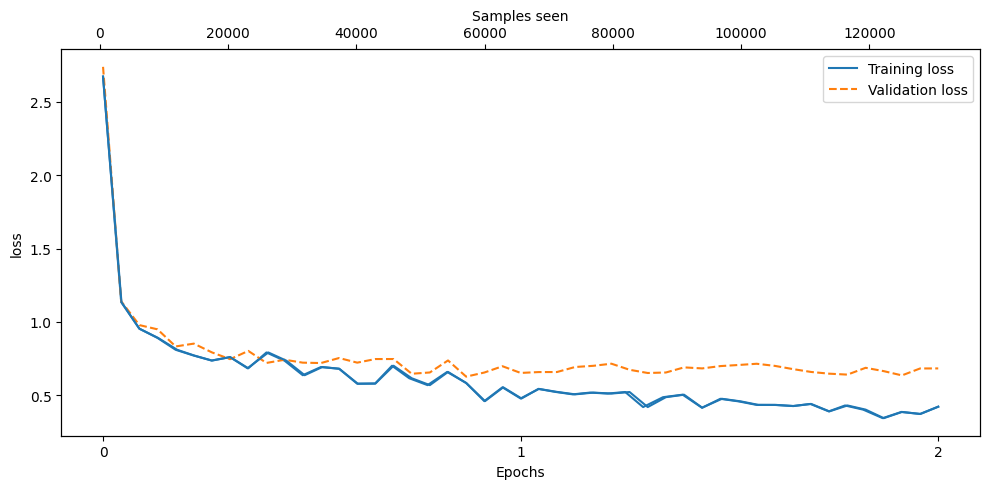

In [18]:
epochs_tensor = torch.linspace(0, epochs, len(train_losses))
plt = Plots(num_tokens_seen, epochs_tensor, train_losses, test_losses)
plt.plots('loss', 'instruct_FineTune')

In [ ]:
#Load the instruct fine-tuned model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)
model_fileName = model_name + '_instruct_FineTuned.pth'

gpt2_instruct.load_state_dict(torch.load(model_fileName, map_location=device))
gpt2_instruct.to(device)
gpt2_instruct.eval()

Device Available:  cuda


C:\Users\Namrata Thakur\AppData\Local\Temp\ipykernel_10088\307266843.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gpt2_instruct.load_state_dict(torch.load(model_fileN

GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=Fa

In [18]:
torch.manual_seed(123)
_, input_text = format_input_response(val_df[10], inference=True)
print('Input Text:\n',input_text)
print('-----------------')

generate = Text_Generation(model=gpt2_instruct, device=device, tokenizer_model='gpt2')
output_text = generate.text_generation(input_text = input_text, max_new_tokens=35, temp=0.0,top_k= None, eos_id=50256)
print(output_text)
response = (output_text[len(input_text):]).replace("### Response:", " ").replace('Response:', '').strip()
print('Generated Response :: ', response)

Input Text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 What is the capital of Denmark?
-----------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.### Instruction: What is the capital of Denmark?### Response:The capital of Denmark is Copenhagen.
Generated Response ::  The capital of Denmark is Copenhagen.


In [12]:
def save_model_response(data, generate):
    torch.manual_seed(123)

    for i, row in enumerate(data):
        _, input_text = format_input_response(row, inference=True)
        model_output = generate.text_generation(input_text = input_text, max_new_tokens=256, temp=0.0,top_k= None, eos_id=50256)
        model_response = model_output[len(input_text):].replace("### Response:", "").replace('Response:', '').strip()
        data[i]['model_response'] = model_response


    return data

In [ ]:
#Save the model responses of the test data:
generate = Text_Generation(model=gpt2_instruct, device=device, tokenizer_model='gpt2')
test_data_response = save_model_response(test_df, generate)

print('Example Test Data with model response::\n',test_data_response[0])

with open('gpt2_355M_instructionData_response.json', "w") as file:
    json.dump(test_data_response, file, indent=4)

In [20]:
with open('gpt2_355M_instructionData_response.json', "r") as file:
    test_data_response = json.load(file)

print(test_data_response[0])

{'instruction': 'Explain the primary function of the human heart.', 'input': '', 'output': 'The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.', 'model_response': 'The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.'}


In [24]:
for row in test_data_response:
    print('GT: ', row['output'])
    print('Generated: ', row['model_response'].replace('sponse:',''))
    print('------------------------------------')

GT:  The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.
Generated:  The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.
------------------------------------
GT:  He will be reading a novel inspired by his grandmother.
Generated:  He is reading a novel inspired by his grandmother.
------------------------------------
GT:  The government passed the law.
Generated:  The law was passed by the government.
------------------------------------
GT:  The confrontation was inevitable given the circumstances.
Generated:  The decision was inevitable.
------------------------------------
GT:  Opinion-based.
Generated:  The chocolate is the best dessert.
------------------------------------
GT:  young.
Generated:  An antonym of 'old' is 'young'.
------------------------------------
GT:  A synonym for 'hardworking' is 'diligent'.
Gener

#### OLLAMA Evaluation:

In [4]:
#The below three functions are taken as in from ch07.ipynb file of 'Build LLM from Scratch' Book by SR:

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [ ]:
def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and strong bones.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, like willow or cedar.
2. Bark: In some cases, llamas may eat the bark of

In [ ]:
def generate_model_scores(data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(data):
        prompt = (
            f"Given the input `{format_input_response(entry, inference=True)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key].replace('sponse:','')}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data_response, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data_response)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Number of scores: 110 of 110
Average score: 40.71



In [ ]:
model_score_dict = {
    model_fileName : sum(scores)/len(scores)
}

with open('Model_Scores_Record.json', 'w') as file:
    json.dump(model_score_dict, file, indent=2)

